In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.compose import ColumnTransformer


# Data Wrangling

## Import and Select Defaulted Loans

In [252]:
df = pd.read_csv('/Users/hezhen/Desktop/credit_risk_model/accepted_2007_to_2018Q4.csv')
defaulted_loans = df[df['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]
defaulted_loans.drop(columns=['loan_status'], inplace=True)

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/3137467566.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/hezhen/Desktop/credit_risk_model/accepted_2007_to_2018Q4.csv')
/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/3137467566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans.drop(columns=['loan_status'], inplace=True)


In [253]:
df.shape

(2260701, 151)

In [254]:
defaulted_loans.shape

(269320, 150)

## Drop Low or High-cardinality Featues

In [255]:
# Drop low- or high-cardinality categorical values
hige_card_feature = ['desc', 'member_id', 'emp_title', 'id', 'title', 'url', 'zip_code']
defaulted_loans.drop(columns=hige_card_feature, inplace=True)

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/3408825001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans.drop(columns=hige_card_feature, inplace=True)


In [256]:
(defaulted_loans.isnull().sum()/len(df)).sort_values(ascending=False).head(50)

next_pymnt_d                                  0.118795
sec_app_mths_since_last_major_derog           0.118239
orig_projected_additional_accrued_interest    0.118177
payment_plan_start_date                       0.117335
hardship_length                               0.117335
hardship_amount                               0.117335
hardship_start_date                           0.117335
hardship_status                               0.117335
hardship_reason                               0.117335
hardship_type                                 0.117335
hardship_dpd                                  0.117335
hardship_loan_status                          0.117335
hardship_payoff_balance_amount                0.117335
hardship_end_date                             0.117335
deferral_term                                 0.117335
hardship_last_payment_amount                  0.117335
sec_app_revol_util                            0.117152
sec_app_earliest_cr_line                      0.117090
sec_app_fi

In [257]:
# drop columns that contain too much null value
col_null = ['next_pymnt_d', 'sec_app_mths_since_last_major_derog', 'orig_projected_additional_accrued_interest',"hardship_type",'hardship_status','deferral_term',
            'hardship_amount','payment_plan_start_date','hardship_payoff_balance_amount','hardship_loan_status','hardship_start_date','hardship_reason',
            'hardship_last_payment_amount','hardship_length','hardship_end_date','hardship_dpd','sec_app_revol_util','sec_app_chargeoff_within_12_mths',
            'revol_bal_joint','sec_app_collections_12_mths_ex_med','sec_app_fico_range_high','sec_app_fico_range_low','sec_app_num_rev_accts','sec_app_open_act_il',
            'sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_open_acc','sec_app_mort_acc','verification_status_joint','annual_inc_joint','dti_joint']
defaulted_loans.drop(columns=col_null, inplace=True)

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/198856421.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans.drop(columns=col_null, inplace=True)


## Fix Date

In [258]:
defaulted_loans.select_dtypes('object').nunique().sort_values(ascending=False).head(30)

earliest_cr_line             686
issue_d                      139
last_pymnt_d                 136
last_credit_pull_d           119
settlement_date               90
debt_settlement_flag_date     83
addr_state                    51
sub_grade                     35
purpose                       14
emp_length                    11
grade                          7
home_ownership                 6
verification_status            3
settlement_status              3
term                           2
application_type               2
initial_list_status            2
debt_settlement_flag           2
disbursement_method            2
pymnt_plan                     1
hardship_flag                  1
dtype: int64

In [259]:
defaulted_loans[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'settlement_date', 'debt_settlement_flag_date']].head()

,earliest_cr_line,issue_d,last_pymnt_d,last_credit_pull_d,settlement_date,debt_settlement_flag_date
13,Jun-2005,Dec-2015,May-2017,Nov-2017,NaN,NaN
25,Jul-2011,Dec-2015,Apr-2017,Dec-2017,NaN,NaN
30,Dec-1985,Dec-2015,Nov-2018,Mar-2019,NaN,NaN
31,Apr-2007,Dec-2015,Jul-2016,Mar-2018,NaN,NaN
33,Jun-2001,Dec-2015,Feb-2018,Mar-2019,NaN,NaN


In [260]:
defaulted_loans.drop(columns=['settlement_date', 'debt_settlement_flag_date'], inplace=True)
columns_to_transform = ["earliest_cr_line", "issue_d", "last_pymnt_d", "last_credit_pull_d"]

# Convert columns to datetime
for column in columns_to_transform:
    defaulted_loans[column] = pd.to_datetime(defaulted_loans[column], format='%b-%Y')
    defaulted_loans[f'{column}_year'] = defaulted_loans[column].dt.year
    defaulted_loans[f'{column}_month']= defaulted_loans[column].dt.month

defaulted_loans.drop(columns=columns_to_transform, inplace=True)

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/1312950737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans.drop(columns=['settlement_date', 'debt_settlement_flag_date'], inplace=True)
/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/1312950737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans[column] = pd.to_datetime(defaulted_loans[column], format='%b-%Y')
/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/1312950737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a c

Since the year of issuance does not reflect some time continuity or trend (e.g., the older the year, the looser or stricter the economic conditions, lending policies may be), this variable should be used as a categorical variable. In addition, for the date of the last disbursement, it would be more meaningful to calculate the year to date (2018).

In [261]:
defaulted_loans['issue_d_year'] = defaulted_loans['issue_d_year'].astype('category')
defaulted_loans["year_since_last_pymnt"] = 2018 - defaulted_loans["last_pymnt_d_year"]
defaulted_loans.drop(columns=["last_pymnt_d_year"], inplace=True)

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/4131198766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans['issue_d_year'] = defaulted_loans['issue_d_year'].astype('category')
/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/4131198766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans["year_since_last_pymnt"] = 2018 - defaulted_loans["last_pymnt_d_year"]
/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/4131198766.py:3: Setti

## Final Check Data Type

In [262]:
defaulted_loans.select_dtypes(include=['object', 'category']).columns.tolist()

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'settlement_status',
 'issue_d_year']

In [263]:
emp_length = defaulted_loans['emp_length']

# Define a function to clean and convert the data
def clean_emp_length(value):
    if pd.isna(value):  # Handle missing values
        return 0
    value = value.lower().strip()  # Make lowercase and remove extra spaces
    if '10+' in value:  # Handle "10+ years"
        return 10
    elif '< 1' in value:  # Handle "< 1 year"
        return 0
    else:
        return int(value.split()[0])  # Extract the number before "year(s)"

# Apply the function to the emp_length column
defaulted_loans['emp_length'] = emp_length.apply(clean_emp_length)


/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/639824248.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans['emp_length'] = emp_length.apply(clean_emp_length)


In [264]:
defaulted_loans.select_dtypes('number').columns.tolist()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 '

## Correlation

<Axes: >

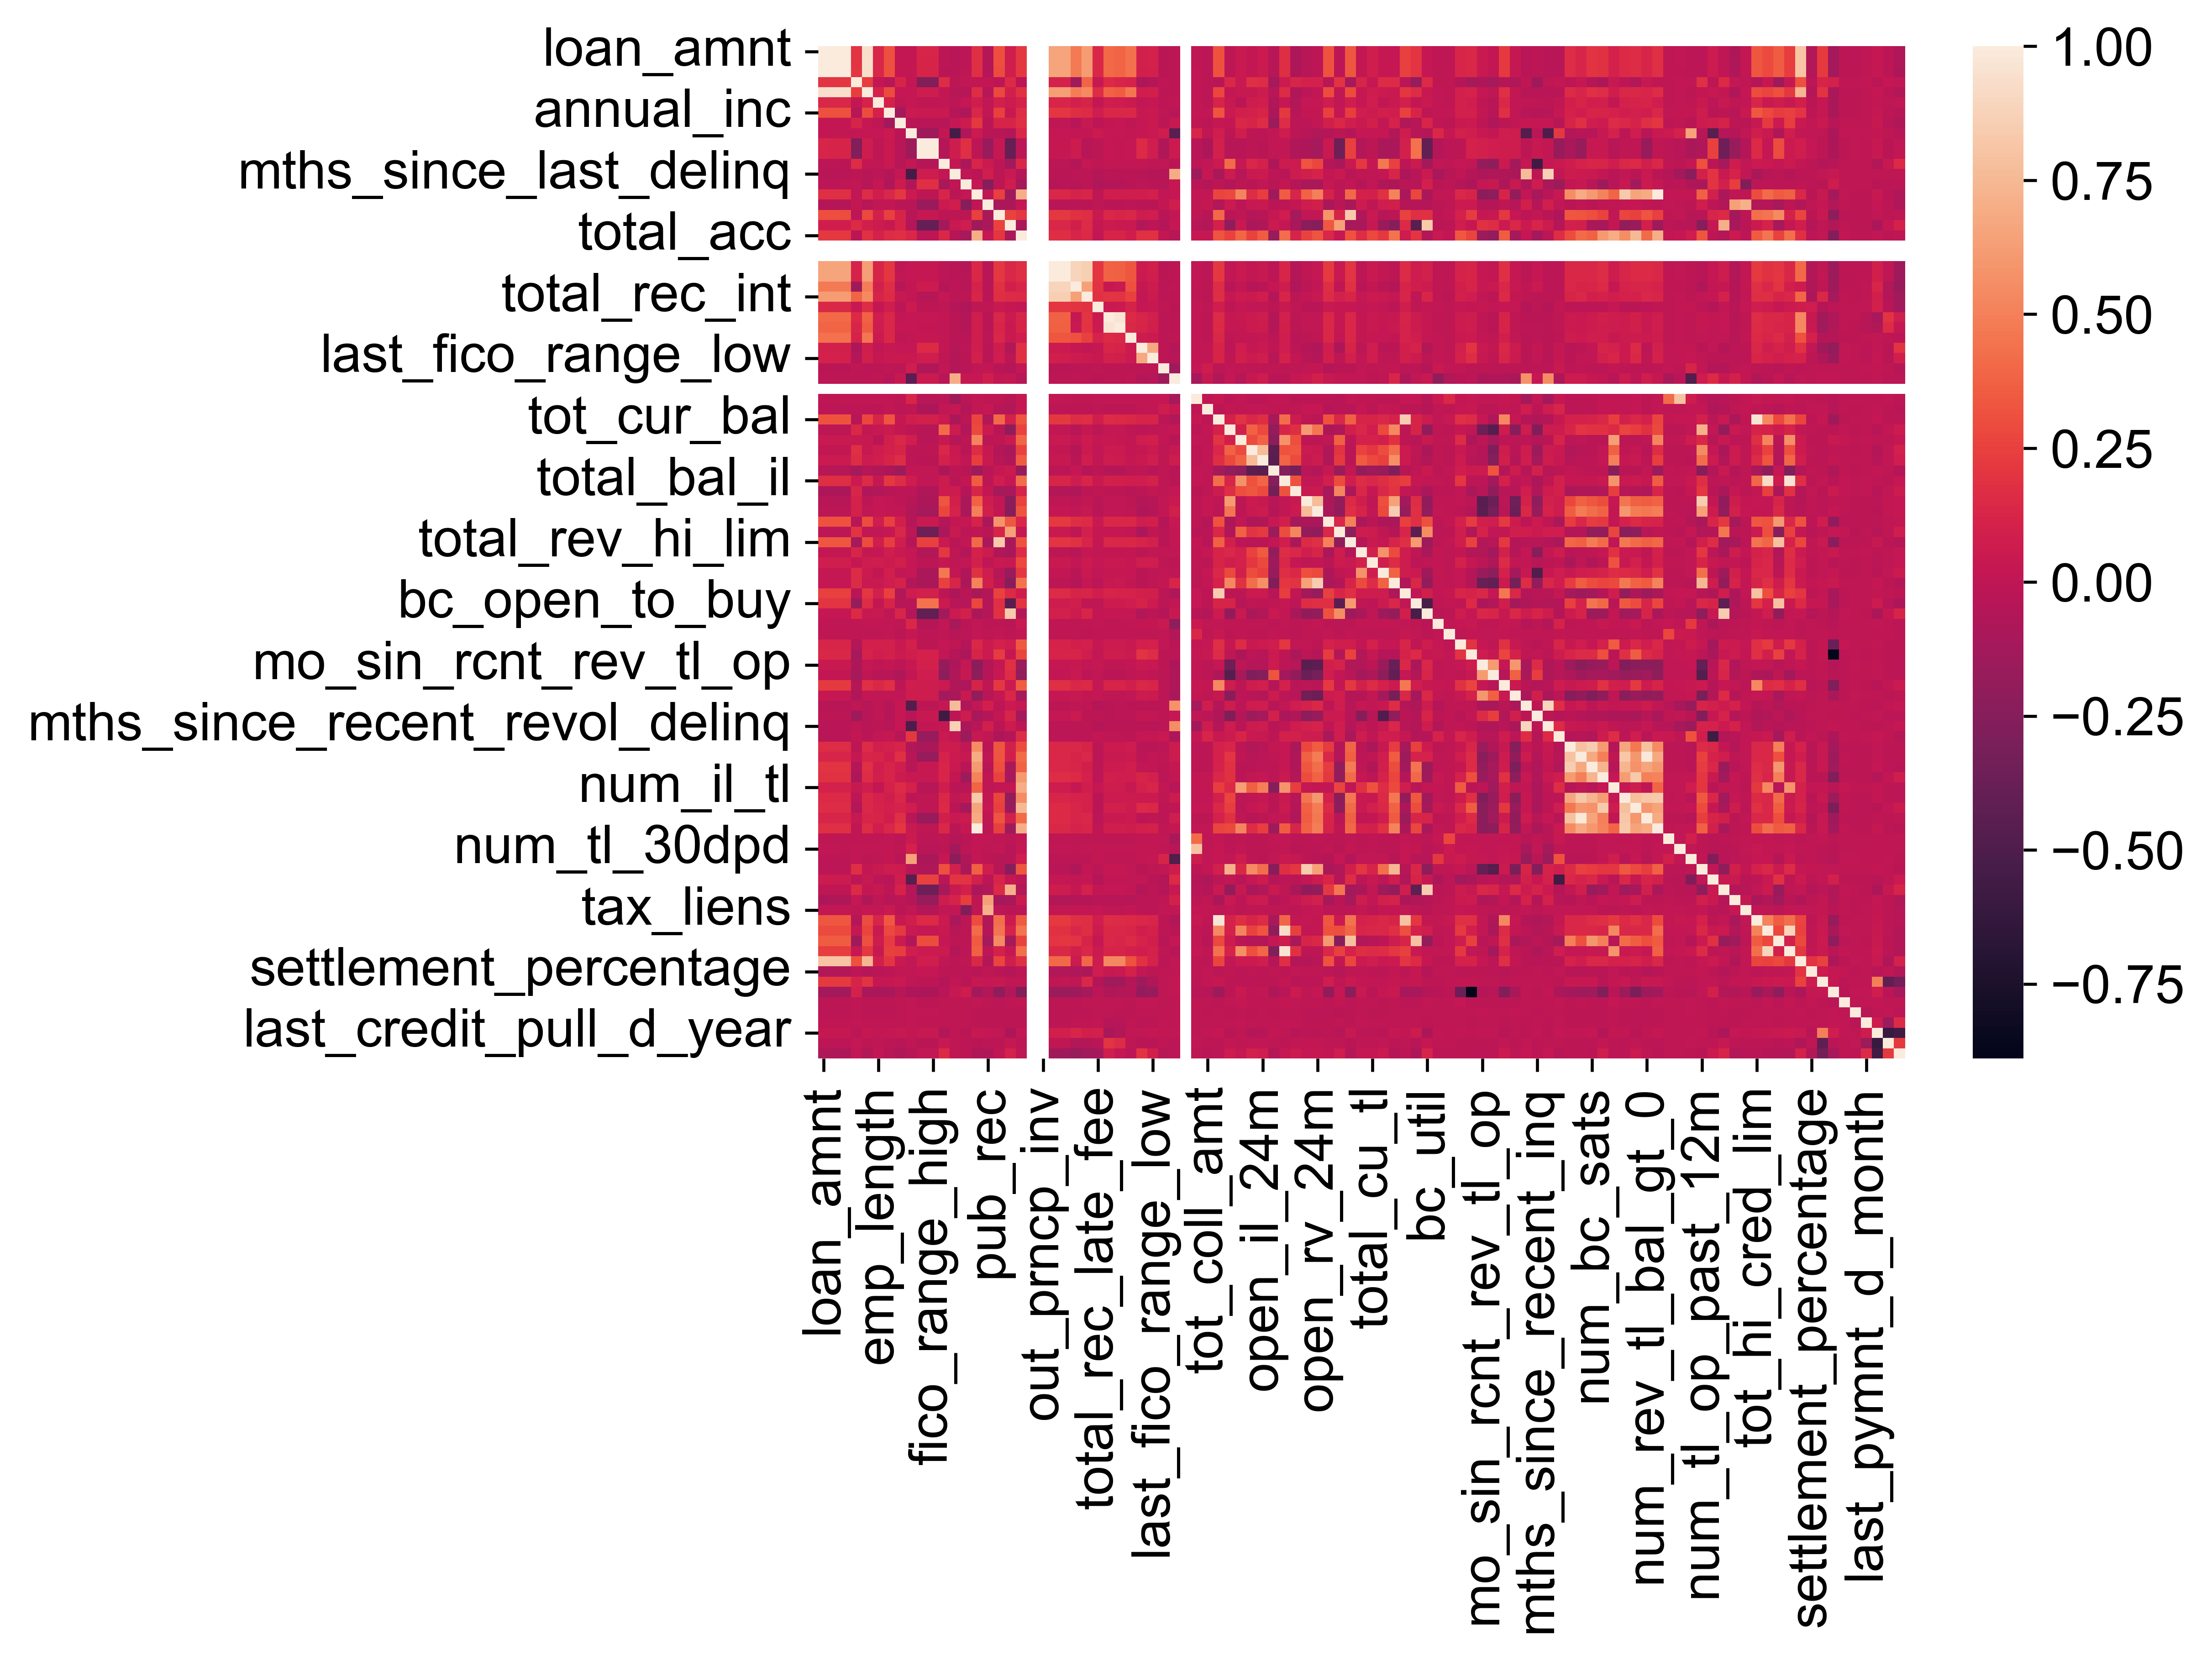

In [265]:
# check correlation
corr = defaulted_loans.select_dtypes('number').corr() # number means continous, we only need feature
plt.figure(dpi=600)
sns.heatmap(corr)

# Explore

## Credit Conversion Factor

In [266]:
defaulted_loans['CCF'] = (defaulted_loans['funded_amnt'] - defaulted_loans['total_rec_prncp']) / defaulted_loans['funded_amnt']

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/466407700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans['CCF'] = (defaulted_loans['funded_amnt'] - defaulted_loans['total_rec_prncp']) / defaulted_loans['funded_amnt']


In [267]:
defaulted_loans.drop(columns=['funded_amnt', 'total_rec_prncp', ], inplace=True)

/var/folders/v6/534wbqz139v6y2kqwgzmrlgr0000gn/T/ipykernel_8336/1811010431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulted_loans.drop(columns=['funded_amnt', 'total_rec_prncp', ], inplace=True)


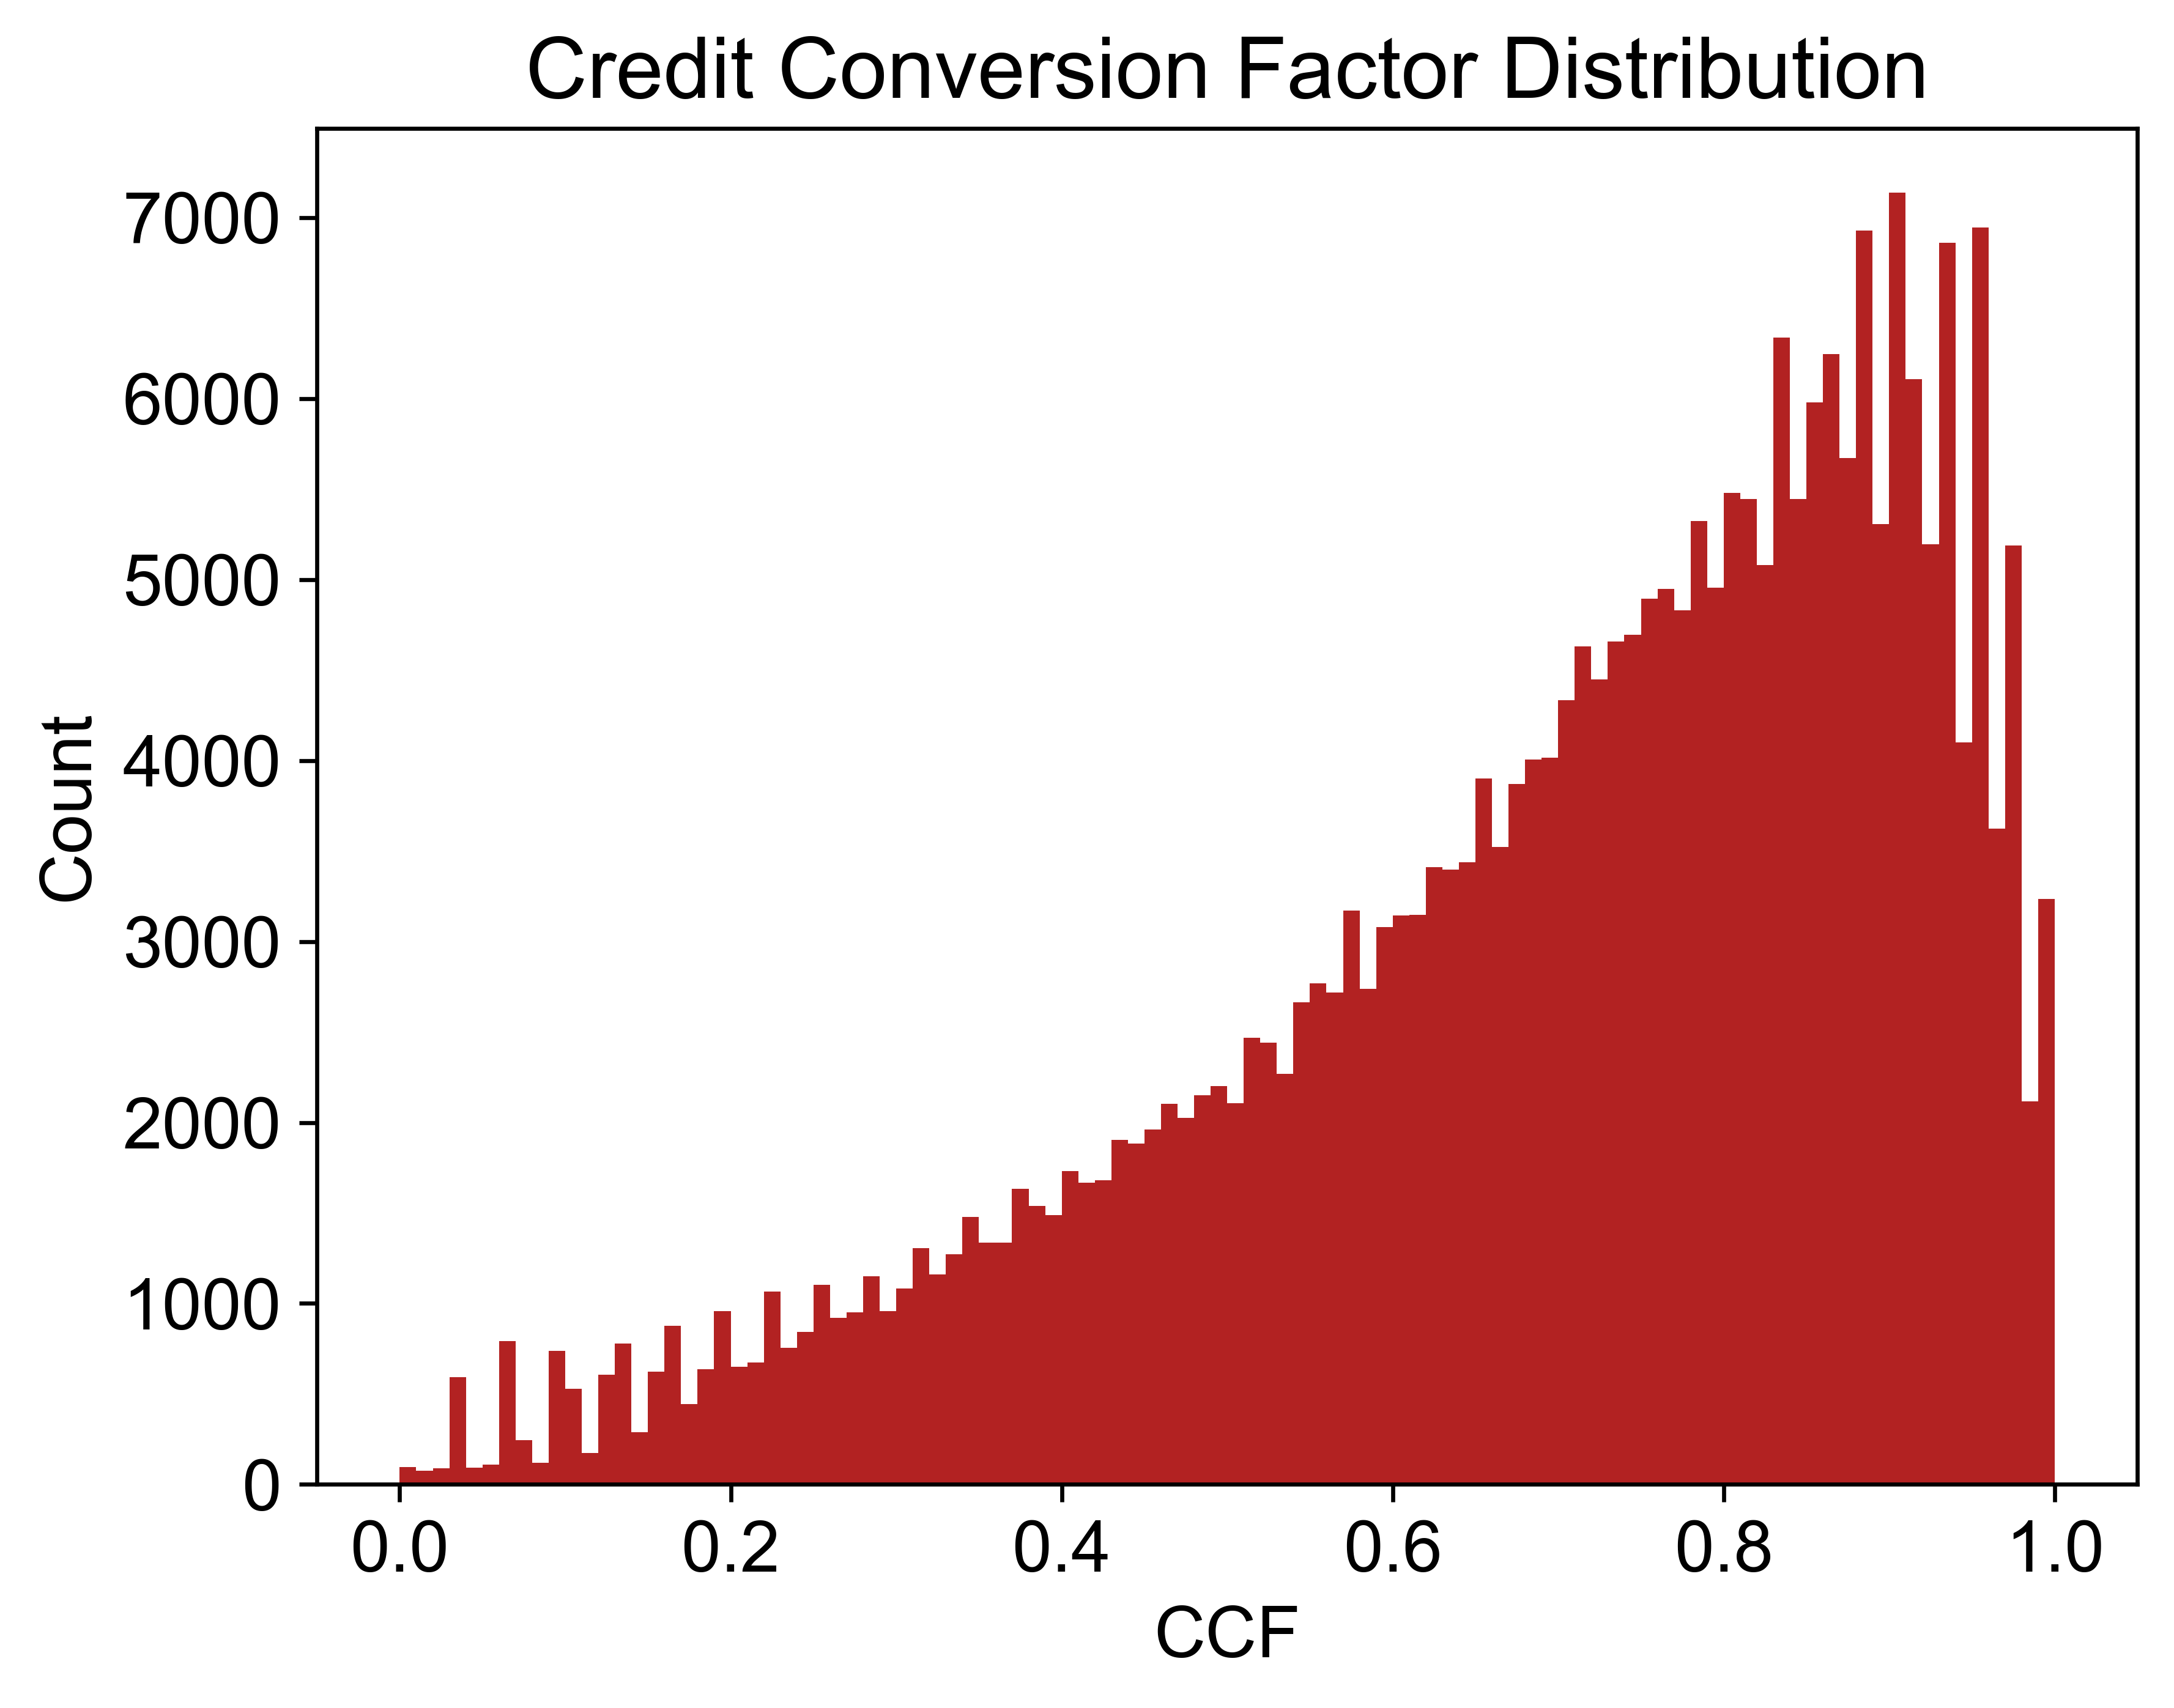

In [268]:
plt.rc('font', family='Arial', size=14, weight='normal') 
plt.figure(dpi=600)
plt.xlabel('CCF', fontdict={'family': 'Arial', 'weight': 'normal'})
plt.ylabel('Count', fontdict={'family': 'Arial', 'weight': 'normal'})
plt.title('Credit Conversion Factor Distribution')
plt.hist(defaulted_loans['CCF'], color='firebrick', bins=100)
plt.show()

In [269]:
defaulted_loans['CCF'].describe()

count    269320.000000
mean          0.697208
std           0.218809
min           0.000000
25%           0.566590
50%           0.747175
75%           0.871866
max           1.000000
Name: CCF, dtype: float64

# Model

## Spilt

In [270]:
X = defaulted_loans.drop(columns=["CCF"])  # Features (all columns except "CCF")
y = defaulted_loans["CCF"]  # Target

In [271]:
X.shape

(269320, 112)

In [272]:
# 60% of data is training
# 20% is validation
# 20% is testing

# First split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Then split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



## Fit Model

In [273]:
model_dict = {}
mae_val_list = []
Ridge_alpha = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.03]

# Placeholder for categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()

categorical_features

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'settlement_status',
 'issue_d_year']

In [274]:
len(numerical_features)

97

In [275]:


# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", make_pipeline(SimpleImputer(), StandardScaler()), numerical_features),
        ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")), categorical_features)
    ]
)

def model_pro(X_train, y_train, X_val, y_val, parameter):
    global model_dict  # Explicitly use the global dictionary

    model = make_pipeline(
        preprocessor,
        Ridge(alpha=parameter)
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Add model to the dictionary
    model_dict[f'Ridge_{parameter}'] = model

    # Calculate r2_validation
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mae_val_list.append(mae)


# Iterate over alpha values
for parameter in Ridge_alpha:
    model_pro(X_train, y_train, X_val, y_val, parameter)

# Output the results
print(Ridge_alpha)
print(mae_val_list)



[0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.03]
[0.044849828299440585, 0.04484982709682599, 0.04484983034588734, 0.044849848028694496, 0.0448499480040908, 0.044850173695940417, 0.044850683897982344, 0.044851235527939445]


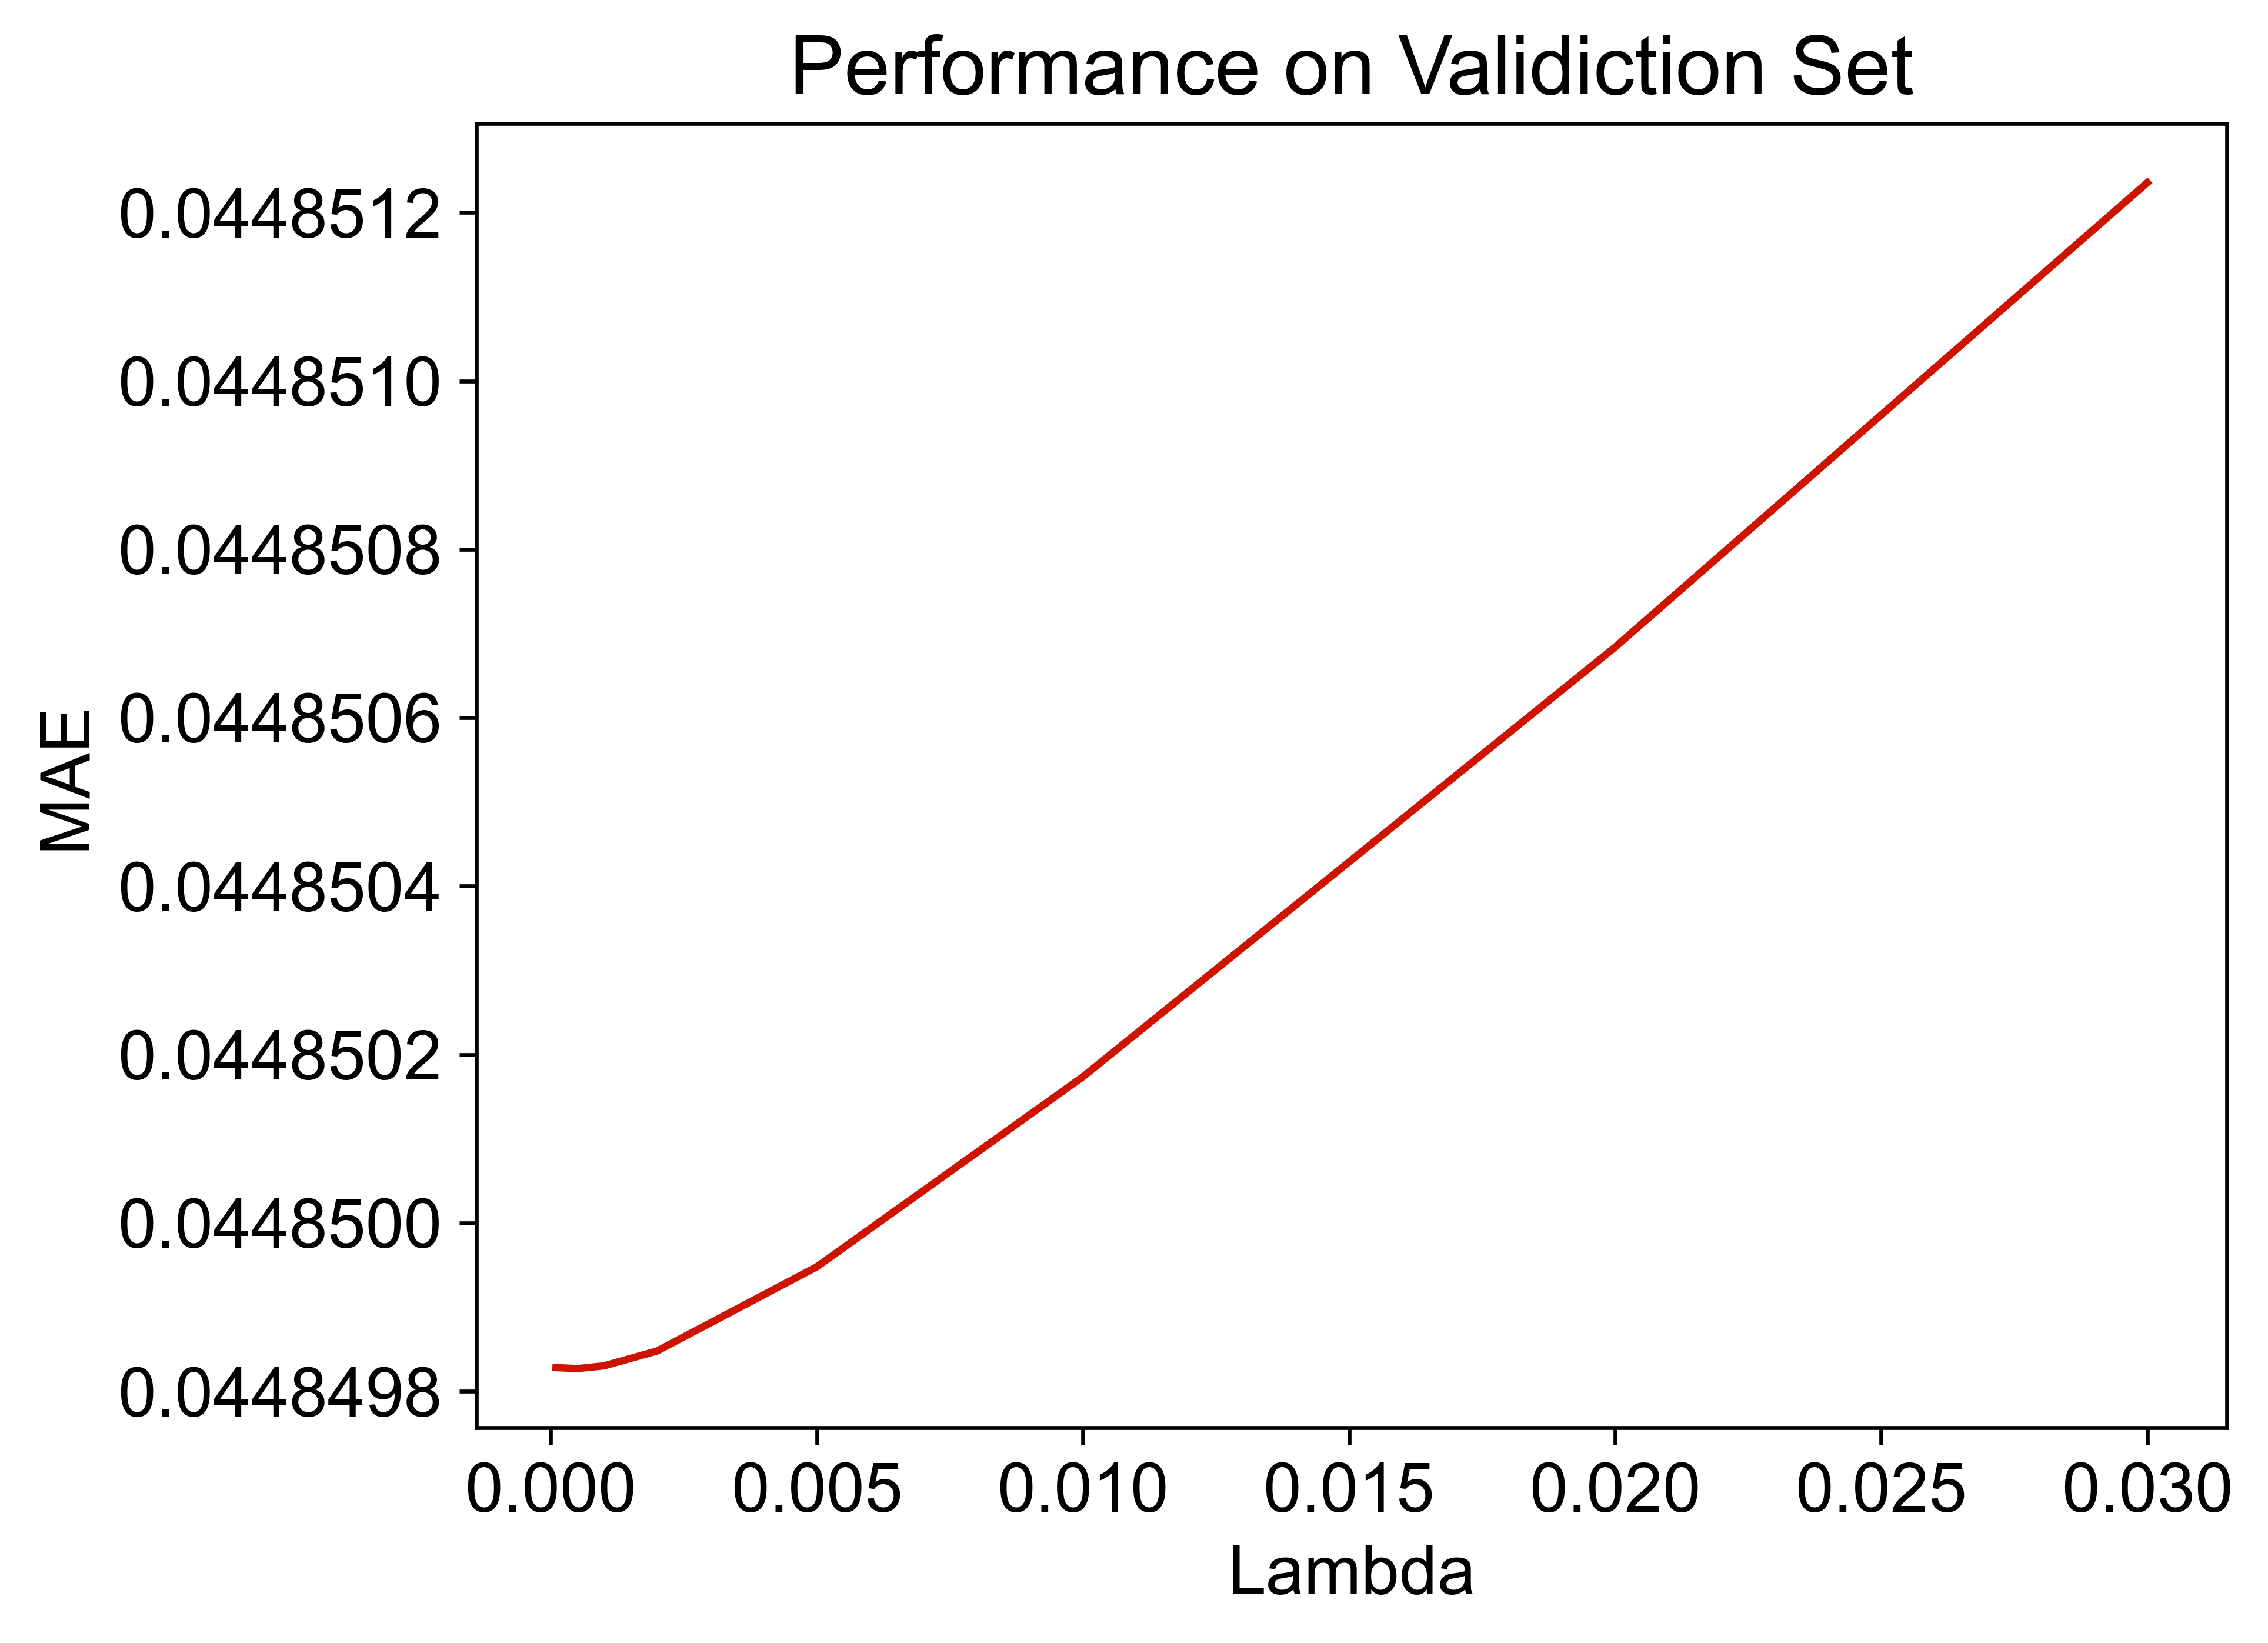

In [276]:
plt.figure(dpi=600)
sns.lineplot(x=Ridge_alpha, y=mae_val_list, color='#CC1400')
plt.xlabel('Lambda')
plt.ylabel('MAE')
plt.title('Performance on Validiction Set')
plt.show()

Model with Lambda = 0.02 preforms best on validation set

In [277]:
model = model_dict['Ridge_0.02'] 
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean absolute error on test set is {}'.format(mae))

Mean absolute error on test set is 0.04463607783075181


# Feature Importance

Text(0.5, 1.0, 'Importance for EAD (TOP 30 Features)')

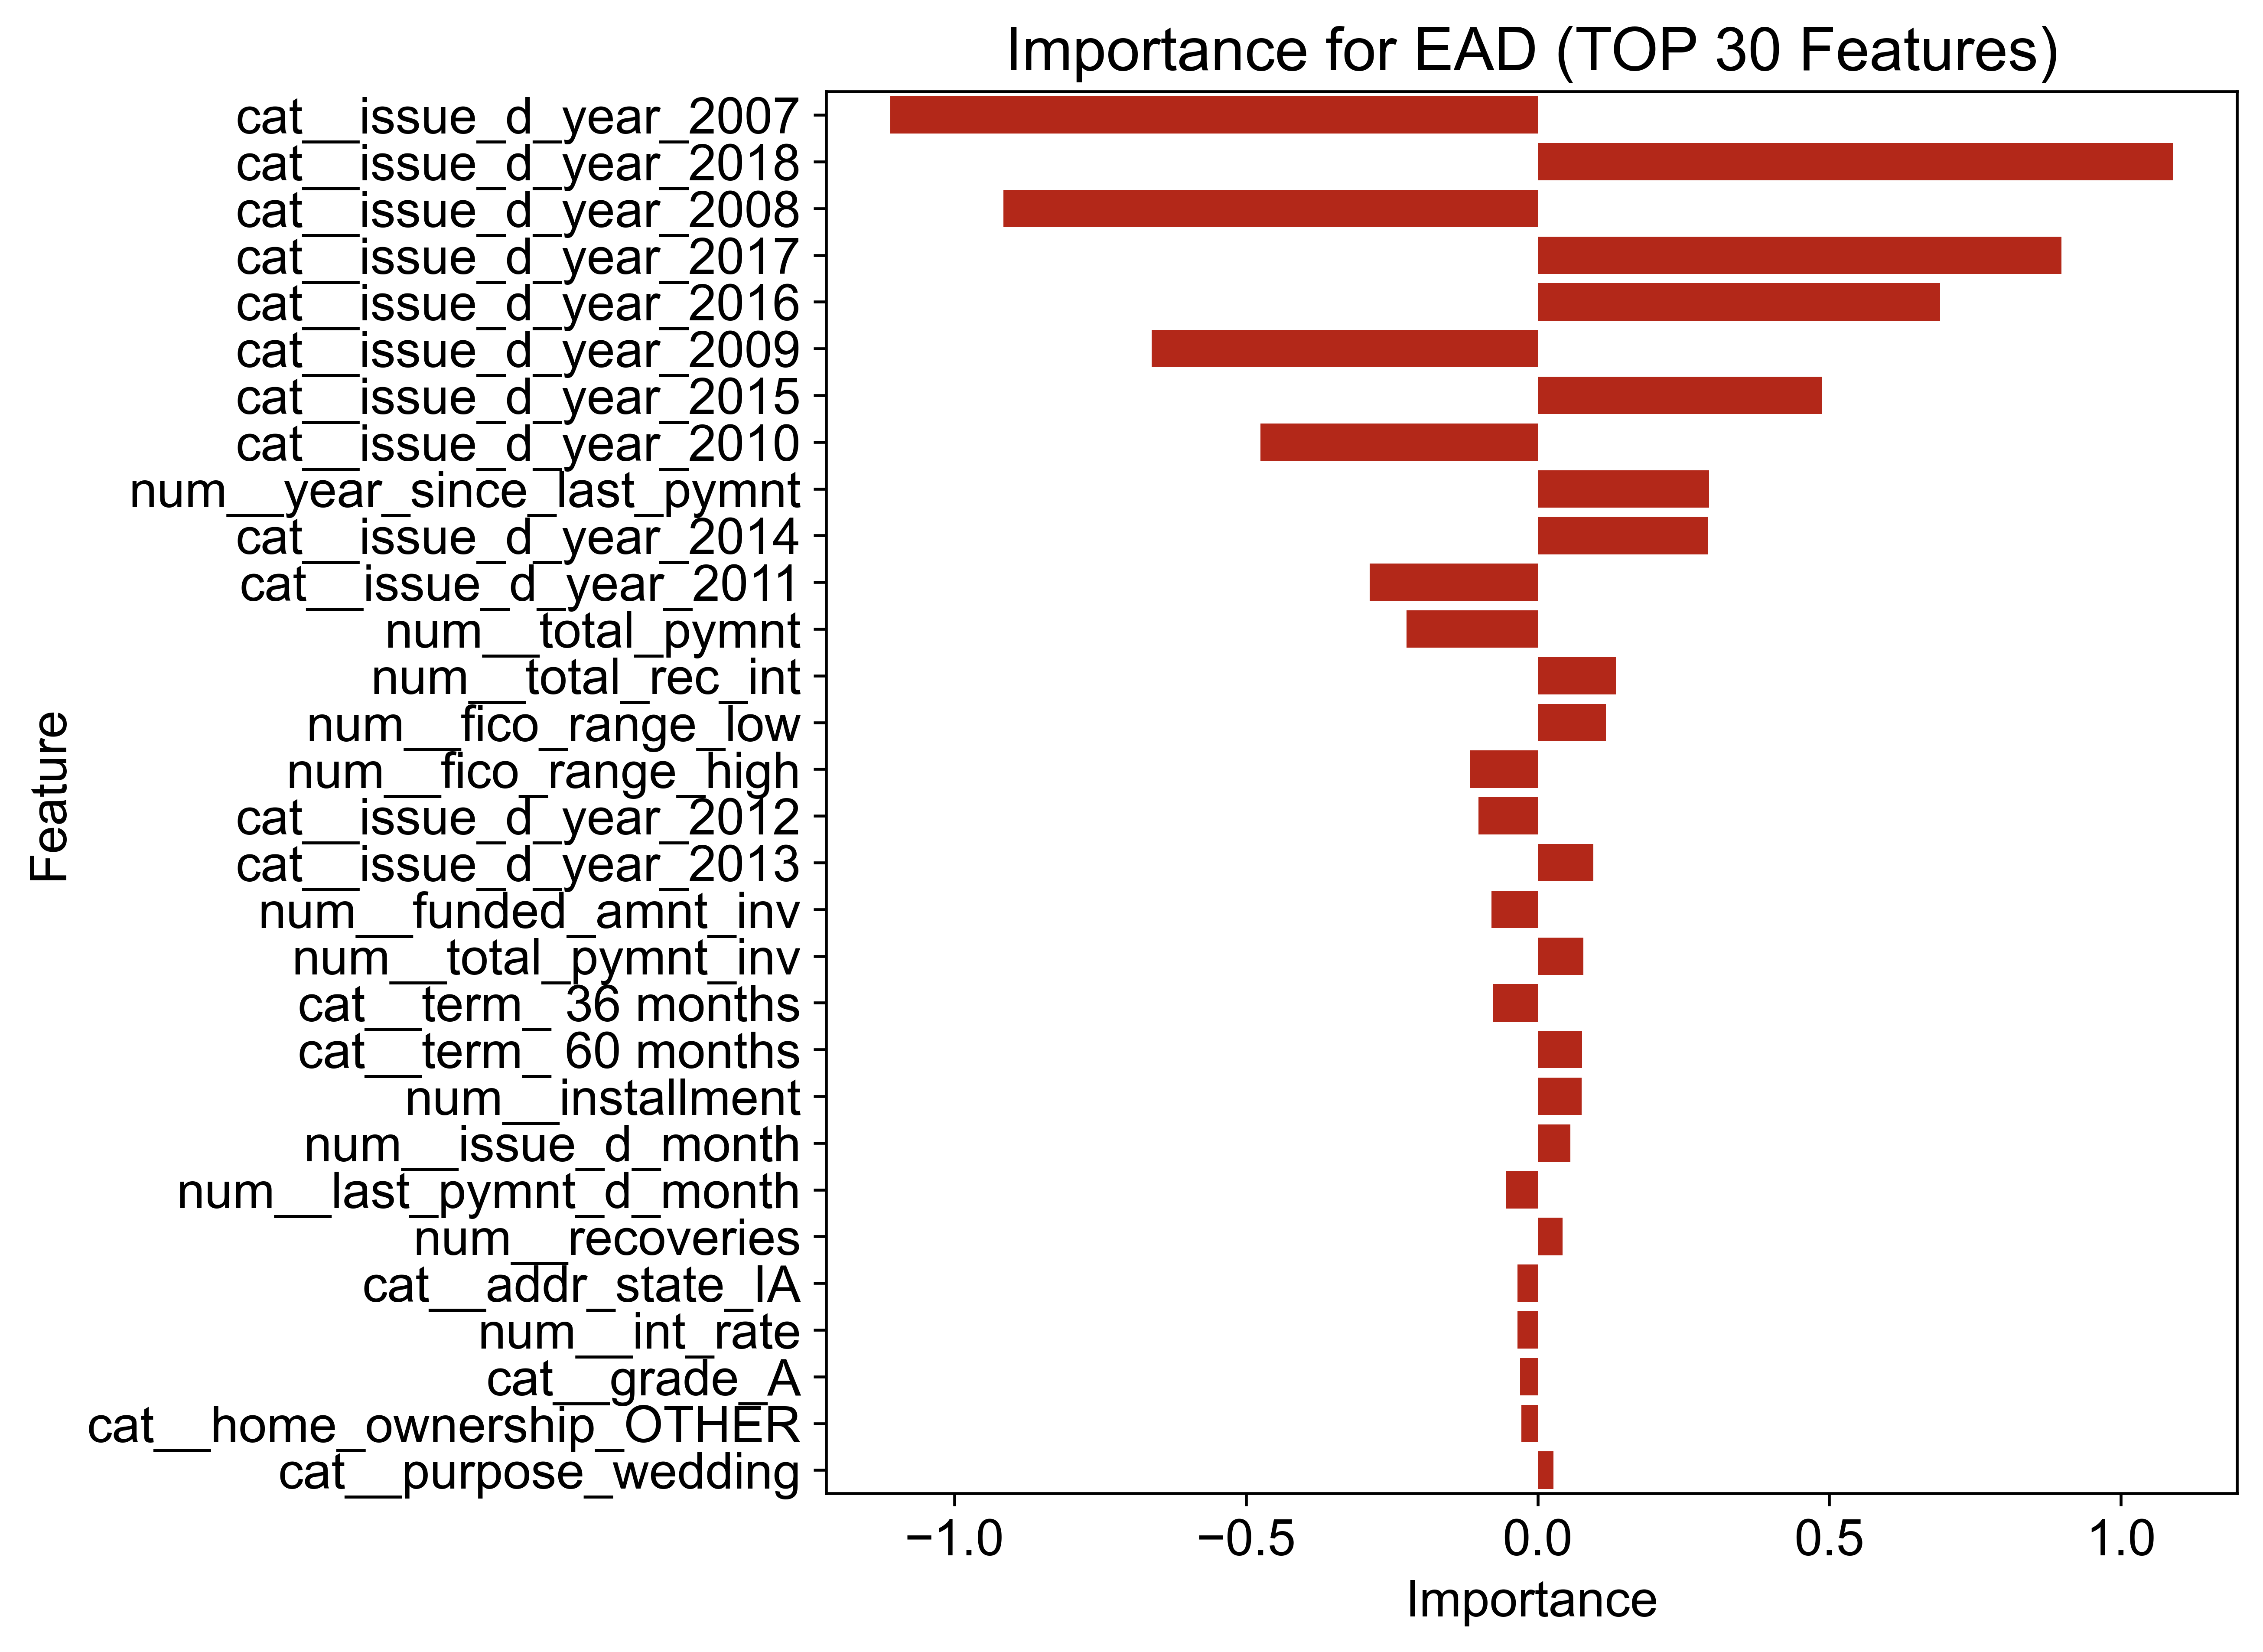

In [278]:
ridge_model = model.named_steps['ridge']  
preprocessor = model.named_steps['columntransformer']  

feature_names = preprocessor.get_feature_names_out()

coefficients = ridge_model.coef_

coef_df = pd.DataFrame(coefficients,feature_names)

i = coef_df.sort_values(key=abs, by=0, ascending=False).head(30)
plt.figure(dpi=600, figsize=(7,7))
sns.barplot(x=i[0] ,y=i.index, color='#CC1400')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance for EAD (TOP 30 Features)')

The year of loan issuance and the time since the last payment play a major role in the exposure at default model.

It is worth noting that loans issued during and after the financial crisis (2007, 2008, 2009, 2010) have smaller exposures, which is in line with financial intuition, as credit funding was tightened and borrowers were scrutinized more stringently after this period. Such a positive contribution (negative coefficient) to the risk exposure decreases year by year.

In 2015, 2016, 2017, and 2018, presumably because of more aggressive quantitative easing by central banks and deregulation, loans issued during this period had the largest exposure and peaked in 2018, which is the final cutoff time for the dataset.

The time since the last payment also has an impact on exposure, with the larger the value, the greater the exposure. This leads to the conclusion that when close to an event of default, borrowers will utilize the loan as much as possible, which increases the risk exposure.

In addition, the change in FICO Score also has an effect, when the change in FICO Score of the borrower is large, it increases the risk exposure.

Text(0.5, 1.0, 'Issue Date Importance')

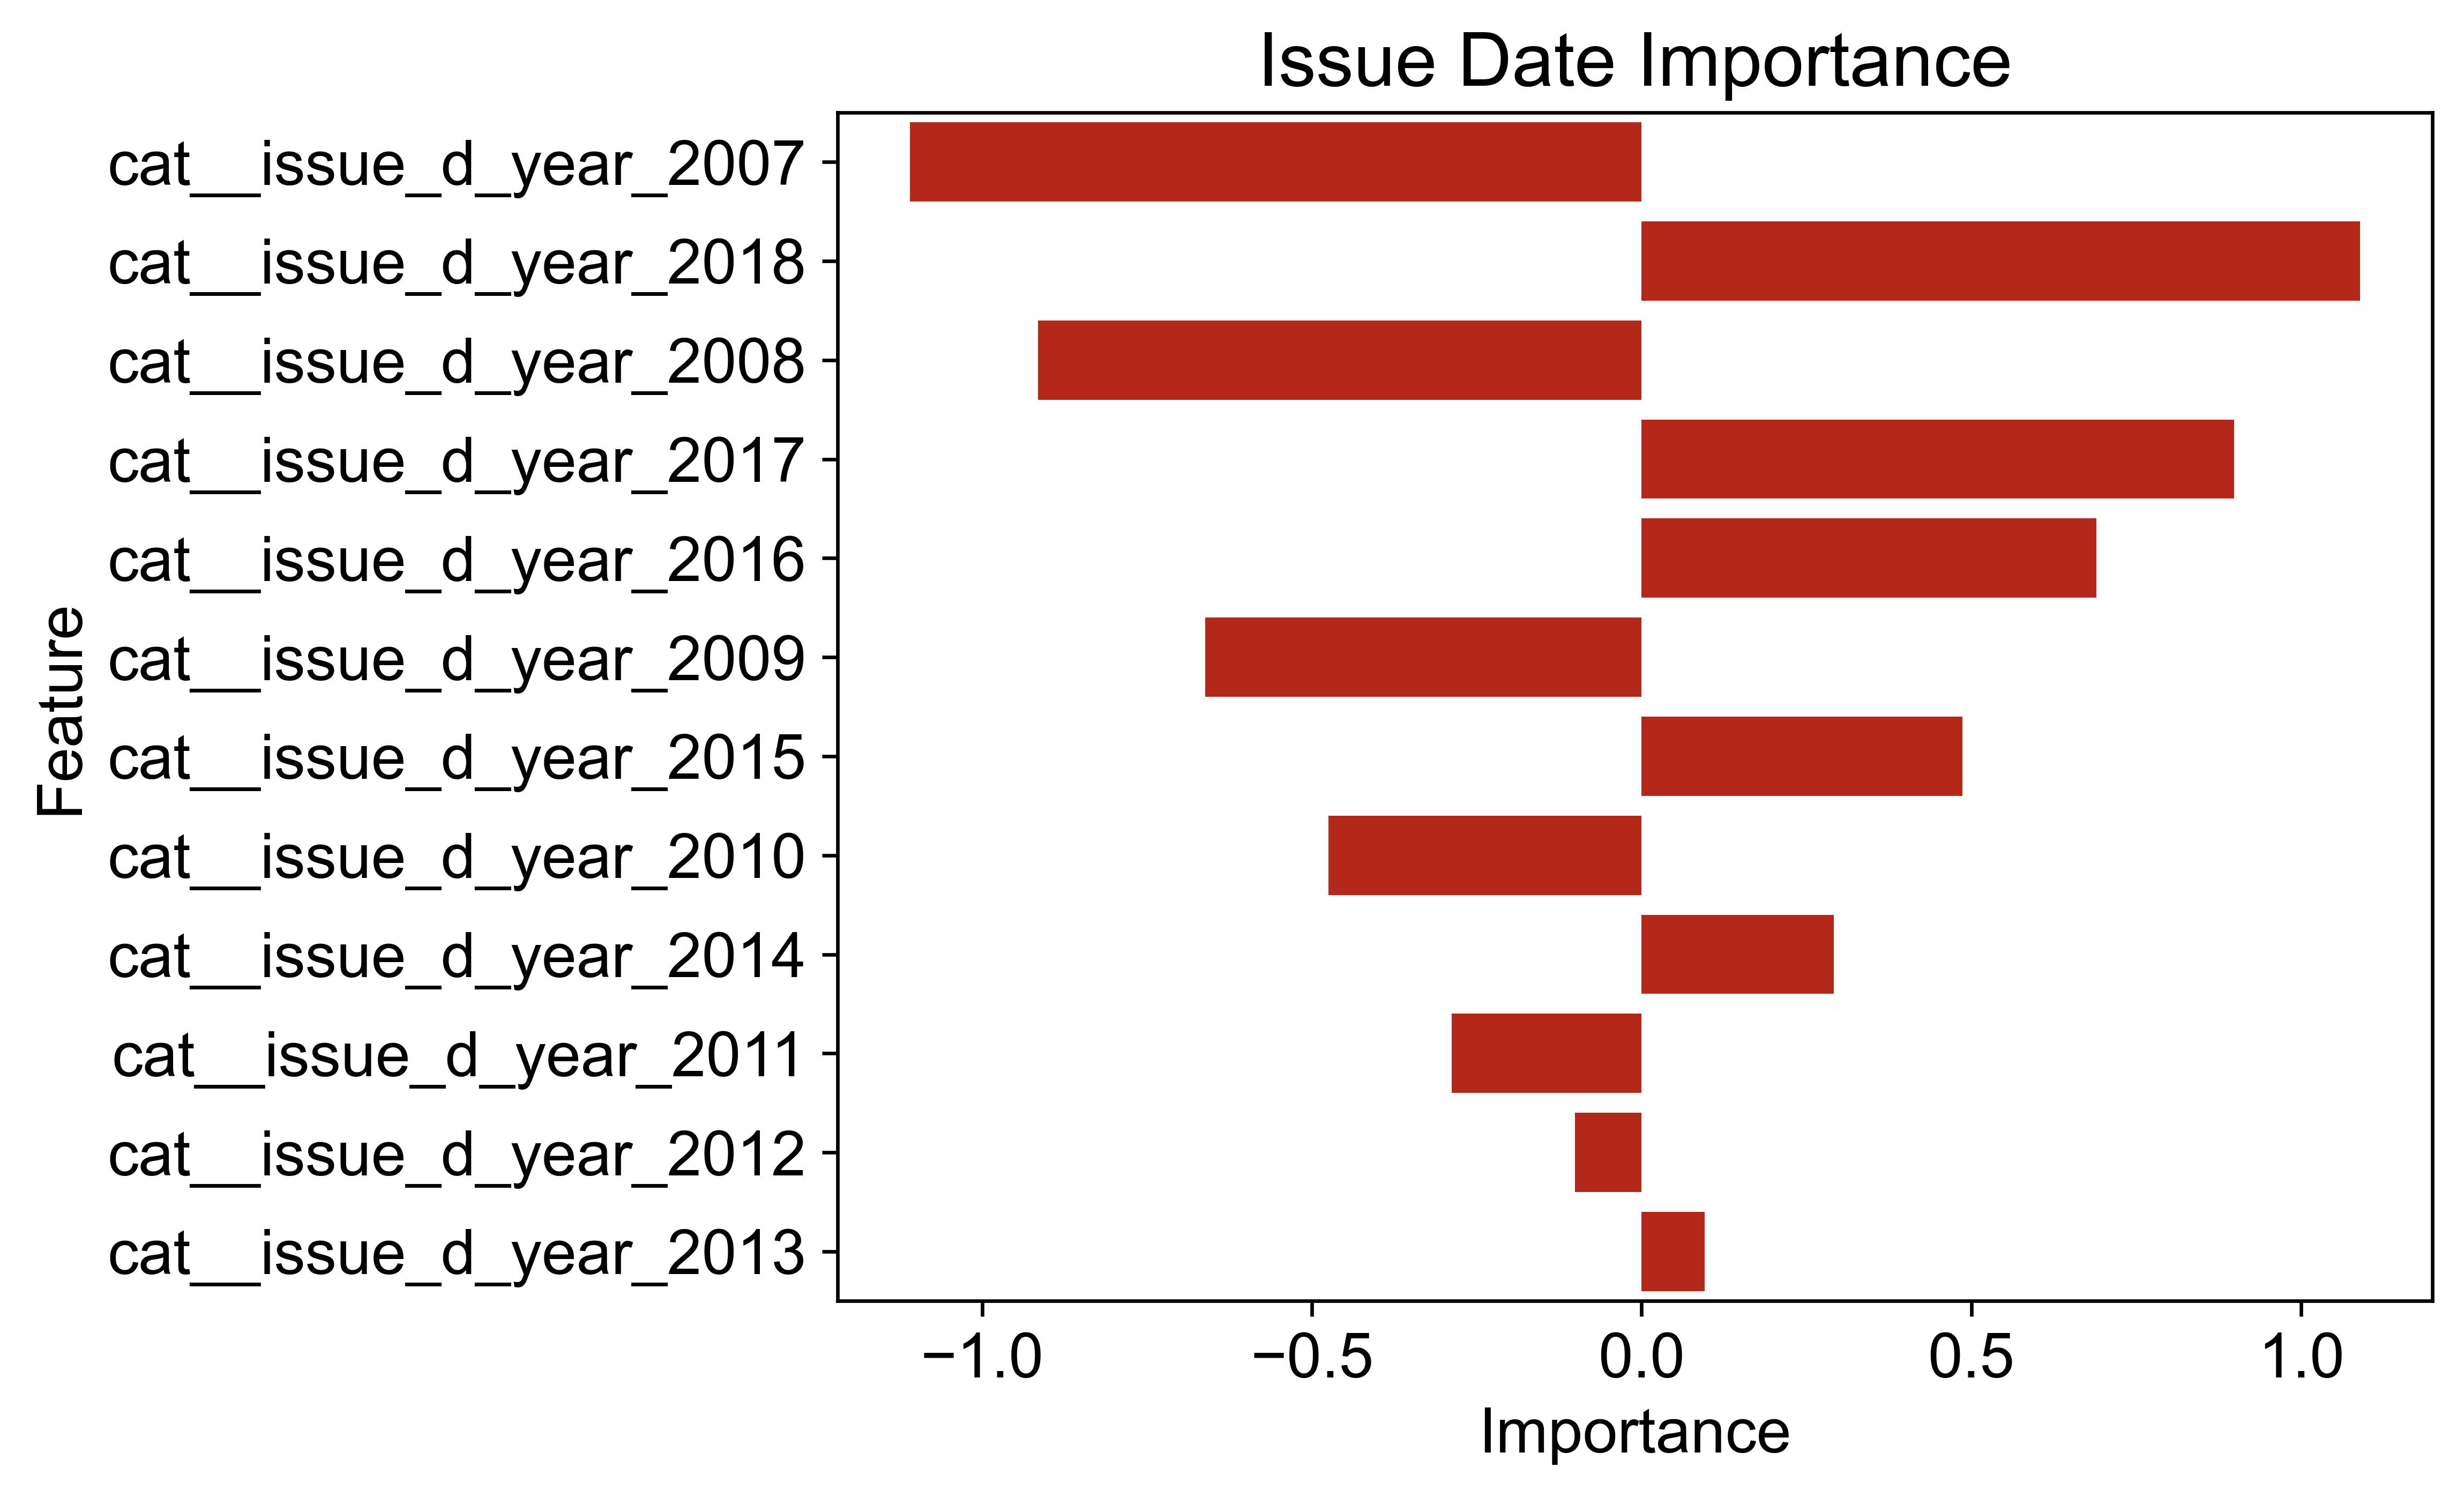

In [284]:
issue_year = coef_df[-12:]
i = issue_year.sort_values(key=abs, by=0, ascending=False).head(15)
plt.figure(dpi=600)
sns.barplot(x=i[0] ,y=i.index, color='#CC1400')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Issue Date Importance')